# AR(1)プロセスの理解と平均の分散


このノートでは図はipynb内に表示し、画像ファイルとしては保存しません。

このノートでは、AR(1)プロセスの基本式と平均の分散を整理し、シミュレーションで確認します。

- **AR(1)プロセス**: $ y_t = \alpha y_{t-1} + \varepsilon_t $, $ |\alpha| < 1 $, $ \varepsilon_t \sim N(0,\sigma^2) $
- **定常分散**: $ \sigma_u^2 = \dfrac{\sigma^2}{1-\alpha^2} $
- **平均の分散**: 


まず平均を

$$
\bar{y}_T = 
\frac{1}{T}\sum_{t=1}^T y_t
$$

と置くと、自己共分散 $\gamma_h=\mathrm{Cov}(y_t,y_{t-h})$ を用いて

$$
\mathrm{Var}(\bar{y}_T)=
\frac{1}{T^2}\sum_{t=1}^T\sum_{s=1}^T\gamma_{|t-s|}
$$

となります。AR(1)では

$$
\gamma_h=\sigma_u^2\alpha^{|h|}
$$

なので、二重和を整理すると

$$
\mathrm{Var}(\bar{y}_T)=
\frac{1}{T^2}\Big(T\gamma_0 + 2\sum_{h=1}^{T-1}(T-h)\gamma_h\Big)
$$

$$
=
\frac{1}{T^2}\Big(T\sigma_u^2 + 2\sum_{h=1}^{T-1}(T-h)\sigma_u^2\alpha^h\Big)
$$

となり、本文の式を得ます。

同じ分散 $\sigma_u^2$ を持つ **iidサンプル** $ x_i \sim N(\mu, \sigma_u^2) $ の平均の分散は

$$
\mathrm{Var}(\bar{x}_T)=
\frac{\sigma_u^2}{T}
$$

であり、相関があると$\mathrm{Var}(\bar{y}_T)$ が増えることを確認します。

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

np.random.seed(42)


In [2]:
def simulate_ar1(alpha, sigma, T, n_simulations=1):
    """AR(1)をシミュレーションする。"""
    y = np.zeros((n_simulations, T))
    epsilon = np.random.normal(0, sigma, (n_simulations, T))

    if abs(alpha) < 1:
        stationary_variance = sigma**2 / (1 - alpha**2)
        y[:, 0] = np.random.normal(0, np.sqrt(stationary_variance), n_simulations)
    else:
        y[:, 0] = epsilon[:, 0]

    for t in range(1, T):
        y[:, t] = alpha * y[:, t - 1] + epsilon[:, t]

    return y


def theoretical_variance_of_sample_mean(alpha, sigma, T):
    """AR(1)の標本平均の理論分散を計算する。"""
    if abs(alpha) >= 1:
        return np.inf

    gamma_0 = sigma**2 / (1 - alpha**2)
    h = np.arange(1, T)
    sum_term = np.sum((T - h) * (alpha ** h))
    variance = (gamma_0 / T**2) * (T + 2 * sum_term)
    return variance


def autocorrelation(x):
    """単純な自己相関推定。"""
    n = len(x)
    variance = x.var()
    x = x - x.mean()
    r = np.correlate(x, x, mode="full")[-n:]
    return r / (variance * np.arange(n, 0, -1))


## シミュレーションで平均の分散を確認


In [3]:
alpha = 0.5
sigma = 1.0
T = 100
n_simulations = 10000

simulated_data = simulate_ar1(alpha, sigma, T, n_simulations)
sample_means = np.mean(simulated_data, axis=1)
empirical_variance = np.var(sample_means, ddof=1)

theoretical_var = theoretical_variance_of_sample_mean(alpha, sigma, T)
iid_variance = (sigma**2 / (1 - alpha**2)) / T

print(f"理論分散: {theoretical_var:.6f}")
print(f"経験分散: {empirical_variance:.6f}")
print(f"比較用のiid分散: {iid_variance:.6f}")
print(f"比 (AR(1) / iid): {theoretical_var / iid_variance:.4f}")


理論分散: 0.039467
経験分散: 0.040007
比較用のiid分散: 0.013333
比 (AR(1) / iid): 2.9600


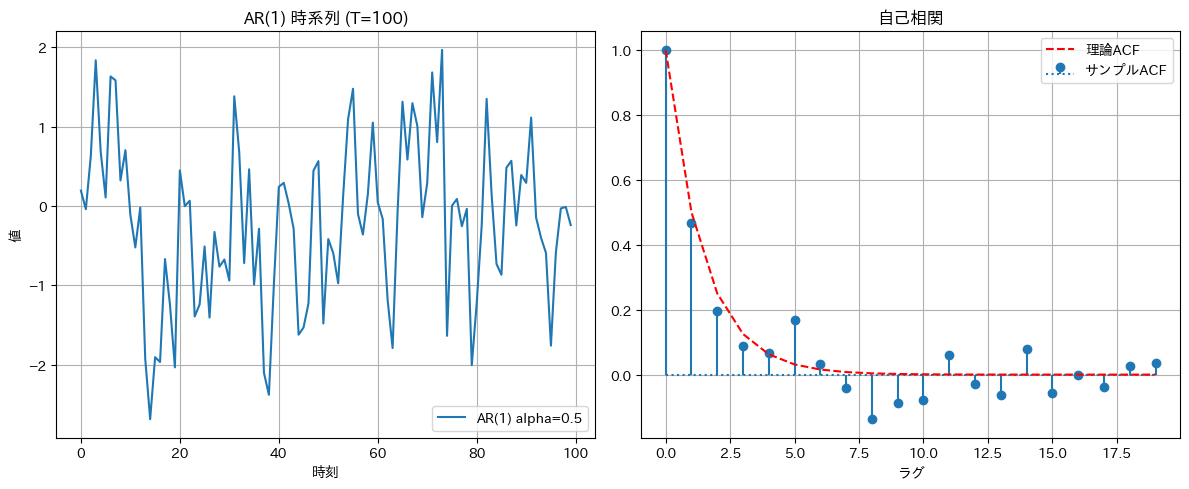

In [4]:
y_single = simulated_data[0]
acf = autocorrelation(y_single)
lags = 20

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_single, label=f"AR(1) alpha={alpha}")
plt.title(f"AR(1) 時系列 (T={T})")
plt.xlabel("時刻")
plt.ylabel("値")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stem(range(lags), acf[:lags], basefmt=":", label="サンプルACF")
plt.plot(range(lags), alpha ** np.arange(lags), "r--", label="理論ACF")
plt.title("自己相関")
plt.xlabel("ラグ")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 相関行列のイメージ

$ \mathrm{Cov}(y_i, y_j) = \sigma_u^2\alpha^{|i-j|} $ なので、対角から離れるほど値が減衰します。


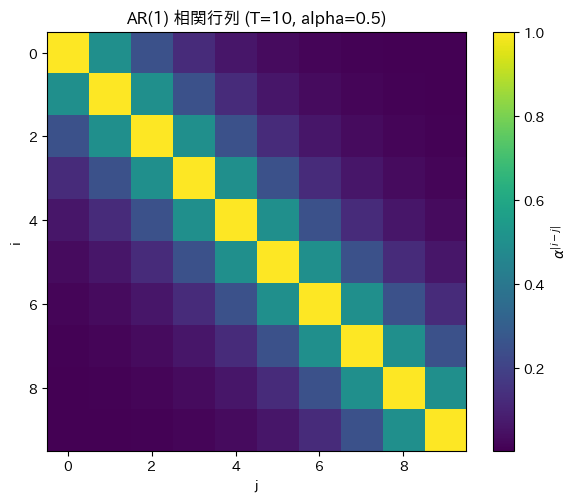

In [5]:
T_matrix = 10
alpha_matrix = 0.5

indices = np.indices((T_matrix, T_matrix))
correlation_matrix = alpha_matrix ** np.abs(indices[0] - indices[1])

plt.figure(figsize=(6, 5))
img = plt.imshow(correlation_matrix, cmap="viridis")
plt.colorbar(img, label=r"$\alpha^{|i-j|}$")
plt.title(f"AR(1) 相関行列 (T={T_matrix}, alpha={alpha_matrix})")
plt.xlabel("j")
plt.ylabel("i")
plt.xticks(np.arange(0, T_matrix, 2))
plt.yticks(np.arange(0, T_matrix, 2))
plt.tight_layout()
plt.show()


## 相関による精度の低下（平均の分散比）

同じ分散 $\sigma_u^2$ を持つ iid サンプル平均との差を比較します。


/tmp/ipykernel_546408/1695024525.py:24: UserWarning: Glyph 563 (\N{LATIN SMALL LETTER Y WITH MACRON}) missing from font(s) IPAexGothic.
  plt.tight_layout()
/home/user/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 563 (\N{LATIN SMALL LETTER Y WITH MACRON}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


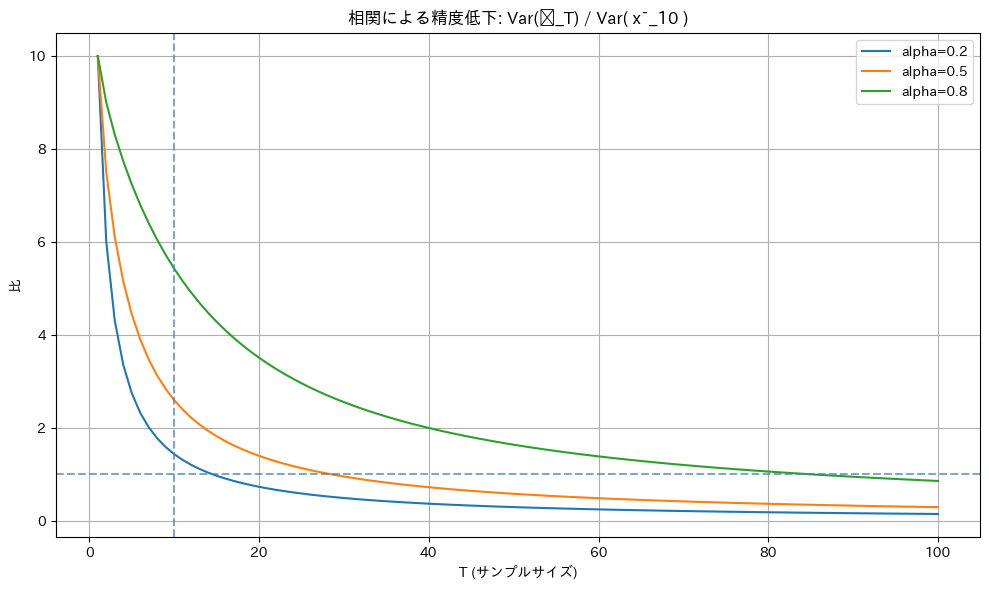

In [6]:
alphas = [0.2, 0.5, 0.8]
T_max = 100
T_range = np.arange(1, T_max + 1)

plt.figure(figsize=(10, 6))

for alpha_val in alphas:
    h_vals = np.arange(1, T_max).reshape(-1, 1)
    t_vals = T_range.reshape(1, -1)
    t_minus_h = t_vals - h_vals
    mask = h_vals < t_vals
    sum_terms = np.sum(t_minus_h * (alpha_val ** h_vals) * mask, axis=0)
    var_terms = T_range + 2 * sum_terms
    ratios = (var_terms / (T_range**2)) / (1.0 / 10.0)
    plt.plot(T_range, ratios, label=f"alpha={alpha_val}")

plt.axhline(y=1.0, color="steelblue", linestyle="--", alpha=0.7)
plt.axvline(x=10.0, color="steelblue", linestyle="--", alpha=0.7)
plt.title("相関による精度低下: Var(ȳ_T) / Var( x̄_10 )")
plt.xlabel("T (サンプルサイズ)")
plt.ylabel("比")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 補足: $x_i$ は比較用の仮想データ

$ x_i $ は $ y_t $ から生成されるわけではなく、**同じ分散を持つ独立サンプル**という比較用の基準線です。
